$\textbf{Exploring Exchange Rate Volatility with Machine Learning}$

In this notenbook I will explore the calculation of volatility with traditional and Machine Learning methods, including Simulated Annealing,  Particle Swarm Optimization, and the Genetic Algorithm,  as well as adaptations of the Quasi-Newton methods.   

We will also use traditional measures of conditional volatility from GARCH estimation (GCV) and the Gelman-Klass method of calculated Range Volatility (GKRV).



$\textbf{Importing the Data from Yahoo Finance}$

We first import the high, low, open and closing series from Yahoo Finance.  Althgh we request the data to start is 2000,
we can only obtain data from 2003-12-01.  You may need to install yfinance



In [6]:
#!pip install yfinance




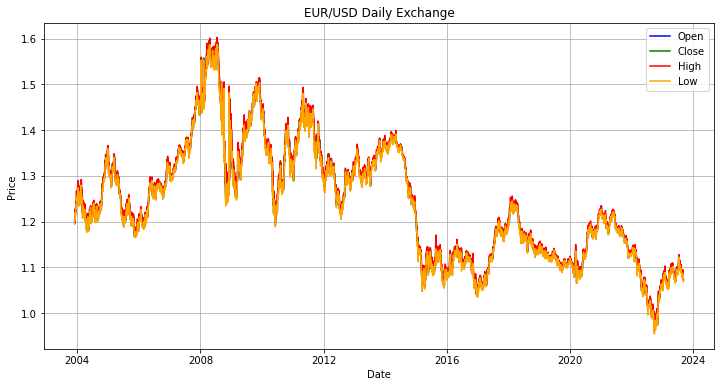

In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define the date range (from 2002-01-01 to today)
start_date = "2002-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Create a Ticker object for EUR/USD
eurusd = yf.Ticker("EURUSD=X")

# Get historical data
eurusd_data = eurusd.history(start=start_date, end=end_date)
import pandas as pd

# Get historical data
eurusd_data = eurusd.history(start=start_date, end=end_date)

# Reset the index to have the date as a separate column
eurusd_data.reset_index(inplace=True)

# Convert the datetime column to timezone unaware
eurusd_data['Date'] = eurusd_data['Date'].dt.tz_localize(None)

# Specify the file path where you want to save the data
#file_path = 'eurusd_data.xlsx'

# Save the data as an Excel spreadsheet
#eurusd_data.to_excel(file_path, index=False)

#print(f"Data saved to {file_path}")
#In the code above, dt.tz_localize(None) is used to remove the timezone information from the 'Date' column in the DataFrame, making it timezone unaware. After making this modification, you should be able to save the data to an Excel file without encountering the timezone-related error.






# Reset the index to have the date as a separate column
eurusd_data.reset_index(inplace=True)

# Interpolate missing or erroneous data points in the 'Close' price series
eurusd_data['Close'] = eurusd_data['Close'].interpolate()

# Correct for specific sudden drops in the 'Low' price series (replace with the previous day's value)
eurusd_data['Low'] = eurusd_data['Low'].mask(eurusd_data['Low'] < 0.8, eurusd_data['Low'].shift(1))

# Extract date and desired columns for plotting
date = eurusd_data['Date']
open_price = eurusd_data['Open']
close_price = eurusd_data['Close']
high_price = eurusd_data['High']
low_price = eurusd_data['Low']
high = high_price
low = low_price
close = close_price
open = open_price

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(date, open_price, label='Open', color='blue')
plt.plot(date, close_price, label='Close', color='green')
plt.plot(date, high_price, label='High', color='red')
plt.plot(date, low_price, label='Low', color='orange')
plt.title('EUR/USD Daily Exchange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



We now calculate the log-first differences of the series.  Note that we have to start the date vector one period later since we lost an observation.

In [9]:
import numpy as np
eurus_diff = np.diff(np.log(close_price))
print(np.mean(eurus_diff))

-2.1345984472466292e-05


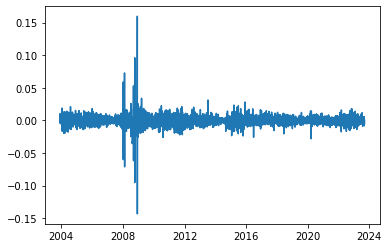

In [10]:
plt.plot(date[1:],eurus_diff)

$\textbf{Range Volatility Measure}$

In [13]:
rangevol1 =  .5*(np.log(high)-np.log(low))**2 - (2*np.log(2)-1)*(np.log(close)-np.log(open))**2;
window_size = 30

# Calculate the rolling window average
rangevol = np.convolve(rangevol1, np.ones(window_size) / window_size, mode='valid')
rangevol = rangevol/rangevol[0]

# Print the rolling average
print(len(rangevol))
print(len(date[window_size-1:]))

5101
5101


Text(0.5, 1.0, 'Garmin-Klass Normalized Range Volatility, Window Size=30')

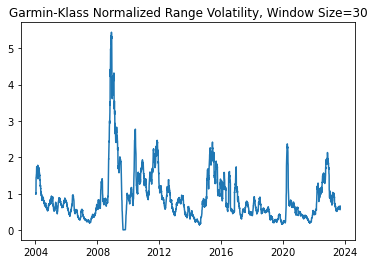

In [15]:
plt.plot(date[window_size-1:], rangevol)
plt.title('Garmin-Klass Normalized Range Volatility, Window Size=30')

$\textbf{GARCH Estimation with AR Term}$

In [16]:
#!pip install arch
import arch

import numpy as np
import pandas as pd
import arch

import numpy as np
import pandas as pd
import arch




y = 100* eurus_diff
model = arch.arch_model(y, vol='Garch', p=1, q=1, dist='StudentsT', mean='ARX', lags=1)

# Fit the GARCH model
results = model.fit(options={'maxiter': 5000})
# Print the model summary
print(results.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4236.497161829875
Iteration:      2,   Func. Count:     22,   Neg. LLF: 4208.777832904701
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4206.265385227441
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4203.431805096293
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4184.988225634638
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4182.455816184786
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4179.162425944121
Iteration:      8,   Func. Count:     86,   Neg. LLF: 4167.467084673246
Iteration:      9,   Func. Count:     94,   Neg. LLF: 4164.032933039668
Iteration:     10,   Func. Count:    104,   Neg. LLF: 4160.944066942326
Iteration:     11,   Func. Count:    114,   Neg. LLF: 4158.025278926922
Iteration:     12,   Func. Count:    123,   Neg. LLF: 4157.026953341912
Iteration:     13,   Func. Count:    132,   Neg. LLF: 4154.608389045004
Iteration:     14,   Func. Count:    140,   Neg. LLF: 4153.78880

5128
5128


Text(0.5, 1.0, 'Normalized GARCH Conditional Variance')

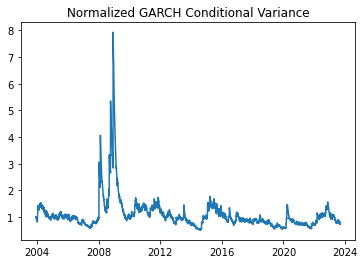

In [26]:
ConVar = results.conditional_volatility

window_size = 1

# Calculate the rolling window averag
ConVar = ConVar[1:]
ConVar1 = np.convolve(ConVar, np.ones(window_size) / window_size, mode='valid')


ConVar1 = ConVar/ConVar[0]
# Print the rolling average
print(len(ConVar1))

date2 = date[2:]
print(len(date2[window_size-1:]))
plt.plot(date2[window_size-1:], ConVar1)
plt.title("Normalized GARCH Conditional Variance")

We see that the conditional volatility is less volatile that the Range Volatility measure.  

$\textbf{The Heston Stochastic Volatility}$


This model has the following continuous time representation:

$dW_{1,t} = \mathcal{N}(0,dt)$

$dS_t = rS_tdt + \sqrt{V_t}dW_{1,t}$

$dW_{2,t} = \rho dW_{1,t} +\sqrt{1-\rho^2}\mathcal{N}(0,dt)$

$dV_t = \kappa (\theta-V_t)dt + \sigma\sqrt{V_t}dW_{2,t}$

$ Corr(dW_{1,t},dW_{2,t})  = \rho $

with the following terms:

dt:  unit of time, for daily data, dt= 1/252

$dW_{1,t}, dW_{2,t}$:  Normally distributed shocks to the mean return and volatility

r:  risk free rate

$dS_t$; rate of return

$dV_t$ rate of change of the stochastic volatility, with restriction $V_t \ge 0$.

$\kappa$: mean-reversion coefficient of the stochastic volatility

$\theta$:  long-term stochastic volatility

$\sigma$: standard deviation of the process for stochastic volatility

$\rho$: correlation of the shocks to stochastic volatility and to returns, with the restriction:  $-1<\rho<1$

$V_0$: initial value for stochastic volatility

Our goal is to go behond the conditional variance of the GARCH, which only depends on the mean prediction errors, to a progress which has correlated shocks to the underlying mean and volatility processes.  From our observations on the daily rate of return, we thus wish to estimate five parameters.

The advantage of continuous time notation is that it is easy to shift estimation from daily to weekly or monthly data by changing the values of dt. 




$\textbf{Issues} for Empirical Implementation$

- Issue: we need to select how we minimize a function
- But what is our accuracy measure?  
- This is our first choice or hyperparameter decision: how to we optimize a function
- We have several choices: global vs. local methods, gradient vs stochastic search methods
- We also have to come to terms with non-convex error functions, there may be several local minima or saddle points
- The search for better optimization methods for nonlinear functions predates Machine Learning
- But Machine Learning or Computational Learning has contributed to this research agenda.



$\textbf{Estimation Objective}$


With various methods, we can have the objective of maximizing the Maximum Likelihood (ML) or, with the Generalized Method of Moments (GMM), minimizing the squared difference between key moments of the actual and simulated data of the model.

Maximum likelihood imposes the restriction of nomrally distributed shocks to the model. The ML method simply calculates the differences between the actual and predicted returns as well as the variance: 

$\hat{\epsilon}_t = dS_t- \hat{dS}_t$ 

$\hat{\sigma}^2 = \frac{\sum_{t=1}^{N} \hat{\epsilon}_t^2}{N - k}$

and maximizes the log-likelihood function:

$\ln(\mathcal{L}) =  -N .5 \pi \sigma - .5 \Sigma (\frac{\hat{\epsilon}_t}{\sigma})^2$

where N is the number of observations and k is the number of parameters to be estimated. In our case, k=5.

The other method is the Generalized Method of Moments.  We simply calculate many moments of the actual and simulated data,
such as the first through fourth moments, for the mean, variance, skewness, and kurtosis.  We also calculate the autocorrelations of both actual data and simulated data, as well as the same autocorrelations of the squared values of the acutal and simulated data.  We them calculate the sum of squared differences beteen the moments of the actual and simulated data.











$\textbf{Local Gradient-Based Search:  The Quasi-Newton Method and Backpropagation}$

To minimize any non-linear function, we usually begin by ”initializing”  the parameter vector $\Omega$ at any initial value, $\Omega_{0}$,perhaps at randomly chosen values. We then ”iterate” on the coefficient set $\Omega$ until an error metric $ \Psi$ is minimized, by making use of first and second-order derivatives of the ”error metric” $\Psi$  with respect to the parameters.  This type of search, called a ”gradient-based search”, is for the optimum ”in the neighborhood” of the initial parameter vector, $\Omega_{0}$  For this reason, this type of search is a ”local” search.

The usual way in which one goes about doing this iteration is through the quasi-Newton algorithm. Starting with the initial set of sum of squared errors, $\Psi(\Omega_{0})$, based on the initial coefficient vector $\Omega_{0}$, a second-order Taylor expansion is used to find $\Psi(\Omega_{1}):\Psi(\Omega_{1})=\Psi(\Omega_{0})+\nabla_{0}(\Omega_{1}-\Omega_{0})+.5(\Omega_{1}-\Omega_{0})^{\prime}H_{0}(\Omega_{1}-\Omega_{0})$

where $\nabla_{0}$ is the gradient of the error function with respect to the parameter set $\Omega_{0}$ and $H_{0\text{ }}$ is the Hessian of the error function.

Letting $\Omega_{0}=[\Omega_{0,1},...\Omega_{0,k}]$, be the initial set of k parameters used in the network, the gradient vector $\nabla_{0}$ is defined as follows:

$\nabla_{0}=\left(\begin{array}{c}
\frac{\Psi(\Omega_{0,1}+h_{1},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{1}}\\
\frac{\Psi(\Omega_{0,1}...\Omega_{0,i}+h_{i}...,\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{i}}\\
.\\
.\\
\frac{\Psi(\Omega_{0,1},...\Omega_{0,i}..\Omega_{0,k}+h_{k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{k}}
\end{array}\right)$

The denominator $h_{i}$  is usually set at max($\epsilon$,$\epsilon$$\Omega_{0,i})$,with $\epsilon=10^{-6}$.

The Hessian $H_{0}$ is the matrix of second-order partial derivatives of $\Psi$ with respect to the elements of $\Omega_{0}$, and are computed in a similar matter as the Jacobian or gradient vector.  The cross-partials or off-diagonal elements of the matrix $H_{0\text{ }}$ are given by the formula:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}\partial\Omega_{0,j}}=\frac{1}{h_{j}h_{i}}\left[\begin{array}{c}
\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j}+h_{j},...\Omega_{0,k})-\Psi(\Omega_{0,1}...\Omega_{0,i,...}\Omega_{0,_{j}}+h_{j}...\Omega_{0,k})\}\\
-\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})\}
\end{array}\right]$

The direct second-order partials or diagonal elements are given by:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}^{2}}=\frac{1}{h_{i}^{2}}\left(\begin{array}{c}
\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},...\Omega_{0,k})-2\Psi(\Omega_{0,1},...\Omega_{0,k})\\
+\Psi(\Omega_{0,1},...,\Omega_{0,i}-h_{i},...\Omega_{0,k})
\end{array}\right)$

$\textbf{Implementations of Quasi-Newton Gradient Methods}$

Implementing the Quasi-Newton methods has been the challenge of computational methods.  The reason is that inverting the Hession method is, as the Brazilians would say, "um bicho de sept cabesas", or "a best with seven heads".  But there is also the vanishing gradient problem.  

- The error fuction from estimation is a function of the parameters we are trying to obtain, as well as the data set:
- The estimation problem becomes a function estimation problem
- $\Phi = f(\Omega;x,y)$
- Unlike Ordinary Least Squares, this function does not have a closed-form solution
- We have to iterate to find the optimal $\Omega^*$ starting with an initial guess, $\Omega_0$
- We use a second-order Taylor expansion:  
- $\Phi(\Omega_1) = \Phi(\Omega_0) + f'(\Omega_0)(\Omega_1 - \Omega_0)+ \frac{1}{2} (\Omega_1 - \Omega_0)' f''(\Omega_0) (\Omega_1 - \Omega_0)$
- Optimization yields the following:  $\Omega_1 = \Omega_0 - \frac{f'(\Omega_0)}{f''(\Omega_0)}$



- If $\Omega$ is a large vector of coefficients, the second derivative or Hessian may be hard, if not impossible, to invert
- So much of the work has been to find ways to approximate the inverse of the Hessian matrix
- Earlier work has been the BFGS method, but the popular one now is called ADAM.
- I will go over these methods in the Jupyther notebook.  They are options we can call with different tools


$\textbf{Stochastic and Grid Search Methods}$

- Some methods are quite simple.  One is Hill Climbing.
- Take initial guesses of the vector $\Omega_0$ as well as lower and upper bounds.
- Define a new vector $\Omega_1 = \Omega_{LB} + Z_k [\Omega_{UB}-\Omega_{LB}]$, where $Z_k$ is a k by 1 random vector
- Accept the new $\Omega_1$ is better than the initial guess, in terms of lower Error metric.
- Contine for many interations
- Another is the Nelder-Mead Simplex Method. It starts with an initial guess and upper and lower bounds.  So there are three vectors.  Rank them from worst to best, $\Omega_i$, i=1,2,3
- The method ranks the three vectors and takes an average of two best, $\Omega_c$
- Then we find $\Omega_r = \Omega_c + \alpha[\Omega_c-\Omega_1]$.  If $\Omega_r$ is best, expand simplex in this direction


$\textbf{All About Adam}$

- Adam stands for Adaptive Moments.

- Adam adapts the learning rate for each parameter during training. It maintains a separate learning rate for each parameter and updates them individually. This adaptiveness helps in converging faster and handling different scales of gradients.

- Exponential Moving Averages:
    1. Adam maintains two exponentially moving average vectors:

    2. First Moment (Mean): This is similar to a moving average of gradients and helps in estimating the mean of the gradient.
    3. Second Moment (Uncentered Variance): This is similar to a moving average of squared gradients and helps in estimating the uncentered variance of the gradient.
    4. Initialization: Adam initializes the first and second moments to zero vectors.

- Hyperparameters
    1. Adam has hyperparameters that control its behavior
    2. There is the learning rate (alpha), decay rates for the moving averages (beta1 for the first moment and beta2 for the second moment), and a small epsilon value (epsilon) added to prevent division by zero.

- Updating Parameters:

    1. For each parameter in the model, Adam calculates its gradient with respect to the loss.
    2. It updates the first moment estimate by taking a weighted average of the current gradient and the previous first moment estimate.
    3. It updates the second moment estimate in a similar manner.
    4. Adam then computes bias-corrected estimates of the first and second moments to account for their initialization at zero.
    5. Finally, it updates the model parameters using these bias-corrected estimates and the learning rate.

$\textbf{Global Methods: SA,GA, and PS}$

- More elaborate methods are Simulated Annealing (SA), the Genetic Algorithm (GA) and Particle Swarm {PS}
- The idea is that we start with randomly chosen candidate vectors for solution and combine then or mutate them in various ways.
- These are global search methods which can span a large surface of candidate solutions
- One practicle way to do optimization is to start with the global methods, and then its solution be the starting vector for a local search method and then a local gradient method.


$\textbf{Simulated  Annealing}$


1. Specify  Temperature   and  ”Cooling Schedule”  Parameter,   $\bar{T}$ 

   Operation:   T(j)= $\frac{\bar{T}}{1+\ln[j]}$

2. Start Random Process at j=0, continue till j=(1,2,...$\bar{T}$)

3. Initialize Solution Vector and Error Metric: 

   $\Omega_{0}, \Psi_{0}$


4.  Randomly Perturbate Solution Vector, Obtain Error Metric for each j: 

    $\widehat{\Omega}_{j}, \widehat{\Psi}_{j}$

5.  Generate P(j) from Uniform Distribution 

     0 $\leq$ P(j) $\leq$ 1

6.    Compute Metropolis Ratio M(j)  

      M(j) $=exp{\left[\frac{-\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right)}{T(j)}\right]}$

7.     Accept New Vector $\widehat{\Omega}_{j}$  Unconditionally if

     $\Omega_{j}= \widehat{\Omega}_{j}{\Leftrightarrow}\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right) <0$ 

8.    Accept New Vector $\Omega_{j}=\widehat{\Omega}_{j}$  Conditionally if:

     P(j) $\leq$ M(j)

9.    Continue process till j= $\bar{T}$ 


$\textbf{Evolutionary Stochastic Search: The Genetic Algorithm}$



Both the Newton-based optimization (including backpropagation) and Simulated Annealing (SA) start with one random initialization vector $\Omega_{0}$.  It should be clear that the usefulness of both of these approaches to optimization crucially depend on how ”good” this initial parameter guess really is.  The genetic algorithm or GA helps us come up with a better ”guess” for using either of these search processes.  

The GA reduces the likelihood of landing in a local minimum.  We no longer have to approximate the Hessians. 
The GA proceeds in the following steps.

1. Population creation

This method starts not with one random coefficient vector $\Omega$, but with a population $N^{\ast}$ (an even number) of random vectors.  

Letting p be the size of each column vector, representing the total number of coefficients to be estimated in the neural network, we create a population $N^{\ast}$ of p by 1 random vectors.  

$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{1}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{2}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}...\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{N\ast}
$

2 Selection

The next step is to select two pairs of coefficients from the population at random, with replacement.  Evaluate the ”fitness” of these four coefficient vectors, in two pair wise combinations, according to the sum of squared error function given above.  Coefficient vectors which come closer to minimizing the sum of squared errors receive ”better” fitness values.

This is a simple fitness ”tournament” between the two pairs of vectors: the winner of each tournament is the vector with the best ”fitness”. These two winning vectors (i,j)are retained for ”breeding” purposes.  While not always used, it has proven to be  extremely useful for speeding up the convergence of the genetic search process.   
$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{j}
$

3 Crossover

The next step is crossover, in which the two parents ”breed” two children.  The algorithm allows ”crossover” to be performed on each pair of coefficient vectors i and j, with a fixed probability p>0.  If crossover is to be performed, the algorithm uses one of three difference crossover operations, with each method having an equal (1/3) probability of being chosen:

1. Shuffle crossover.  For each pair of vectors, k random draws are made from a binomial distribution. If the $k^{th}$ draw is equal to 1, the coefficients $\Omega_{i,p}$ and $\Omega_{j,p}$ are swapped; otherwise, no change is made.

2. Arithmetic crossover. For each pair of vectors, a random number is chosen, $\omega\in(0,1)$. This number is used to create two new parameter vectors which are linear combinations of the two parent factors, $\omega\Omega_{i,p}+(1-\omega)\Omega_{j,p},(1-\omega\Omega_{i,p}+\omega)\Omega_{j,p}$.

3. Single-point crossover. For each pair of vectors, an integer I is randomly chosen from the set [1,k-1].  The two vectors are then cut at integer I and the coefficients to the right of this cut point, $\Omega_{i,I+1},\Omega_{j,I+1}$ are swapped. 

In binary-encoded genetic algorithms, single-point crossover is the standard method.  There is no consensus in the genetic algorithm literature on which method is best for real-valued encoding.  

Following the operation of the crossover operation, each pair of ”parent” vectors is associated with two ”children” coefficient vectors, which are denoted C1(i) and C2(j).  If crossover has been applied to the pair of parents, the children vectors will generally differ from the parent vectors.

4 Mutation

The fifth step is mutation of the children.  With some small probability $\widetilde{pr}$, which decreases over time, each element or coefficient of the two children's vectors is subjected to a mutation.  The probability of each element is subject to mutation in generation $G=1,2,...G^{\ast}$, given by the probability $\widetilde{pr}=.15+.33/G$.

If mutation is to be performed on a vector element, we use the following non-uniform mutation operation, due to Michalewicz (1996).  

Begin by randomly drawing two real numbers $r_{1}$ and $r_{2}$ from the [0,1] interval and one random number s, from a standard normal distribution.  The mutated coefficient $\widetilde{\Omega} _{i,p}$ is given by the following $formula:\widetilde{\Omega}_{i,p}=\left\{ \begin{array}{c}
\Omega_{i,p}+s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}>.5\\
\Omega_{i,p}-s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}\leq.5
\end{array}\right\} $

where G is the generation number, $G^{\ast}$ is the maximum number of generations, and b is a parameter which governs the degree to which the mutation operation is non-uniform.  Usually we set b= 2.  Note that the probability of creating a new coefficient via mutation which is far from the current coefficient value diminishes as $G\rightarrow G^{\ast}$, where $G^{\ast}$ is the number of generations.  Thus, the mutation probability itself "evolves" through time  

The mutation operation is non-uniform since, over time, the algorithm is sampling increasingly more intensively in a neighborhood of the existing coefficient values.  This more localized search allows for some fine tuning of the coefficient vector in the later stages of the search, when the vectors should be approaching close to a global optimum.

5 Election tournament

The last step is the election tournament.  Following the mutation operation, the four members of the ”family” (P1,P2,C1,C2) engage in a fitness tournament.  The children are evaluated by the same fitness criterion used to evaluate the parents.  The two vectors with the best fitness, whether parents or children, survive and pass to the next generation, while the two with the worst fitness value are extinguished.  This election operator is due to Arifovic (1996).  She notes that this election operator "endogenously controls the realized rate of mutation" in the genetic search process [Arifovic (1996): p. 525].

We repeat the above process, with parents i and j returning to the population pool for possible selection again, until the next generation is populated by N* vectors.

6 Elitism

Once the next generation is populated, we can introduce elitism (or not)  Evaluate all the members of the new generation and the past generation according to the fitness criterion.  If the ”best” member of the older generation dominated the best member of the new generation, then this member displaces the worst member of the new generation and is thus eligible for selection in the coming generation.

7 Convergence

One continues this process for $G^{\ast}$ generations.  Unfortunately, the literature gives us little guidance about selecting a value for $G^{\ast}$. Since we evaluate convergence by the fitness value of the best member of each generation, $G^{\ast}$ should be large enough so that we see no changes in the fitness values of the "best" for several generations.  

8  Evolutionary Genetic Algorithms

Just as the genetic algorithm is an "evolutionary search process" for finding the best coefficient set $\Omega$ of p elements, the parameters of the genetic algorithm, such as population size, probability of crossover, initial mutation probability, use of elitism or not, can evolve themselves.  As Fogel and Michalewicz (2002) observe, "let's admit that finding good parameter values for an evolutionary algorithm is a poorly structured, ill-defined, complex problem. But these are the kinds of problems for which evolutionary algorithms are themselves quite adept" [Fogel and Michalewicz (2002): p.281].  They suggest two different ways to do make a genetic algorithm evolutionary.  One, as we suggested with the mutation probability, is to use a feedback rule from the state of the system which modifies a parameter during the search process. Alternatively, we can incorporate the training parameters into the solution by modifying $\Omega$, to include additional elements, such as population size, use of elitism, crossover probability.  These parameters thus become subject to evolutionary search along with the solution set $\Omega$ itself.

$\textbf{The Particle Swarm Algorithm}$

The Particle Swarm algorithm is similar to the GA.  Both start out with a wide set of candidate solutions to the parameter sector.   It is take from the social behavior of animal groups foraging for food, who are able to share information within their group or swarm, which gives them survival knowledge.

Each parameter $\Omega_{i}$is a position vector, or particle, in the swarm and consists of K-elements at iteration t: 

$\Omega_{i}^{t}$ = $[\omega_{i,1}^t, \omega_{i,2}^t ...\omega_{i,k}^t]$, k=1...K,  for i=1.,,,N position vectors

Each position vector tries to optimize a payoff or fitness function $f(\Omega_{i}^t)$

For each position vector, $\Omega_{i}$ there is a Velocity vector $V_{i}^t$.  Each velocity vector is updated at each iteration t, for each of the N position vectors, in the following way:

$V_{i,k}^{t+1} = c_0 V_{i,k}^t + c_1 r_1^t (Pbest_{i,k}-\Omega_{i,k}^t) + c_2 r_2^t(Gbest_{i,k}^t-\Omega_{i,k}^t)$

Given the law of motion of the Velocity of each position vector in the swarm, each position vector updates in the following way:

$\Omega_{i,k}^{t+1}= \Omega_{i,k}^t + V_{i,k}^{t+1}$

The parameter $c_0$ is the inertia coefficient,and is positive, with 0 $\le c_0 \le 1$

The individual cognition term is given by $c_1$.  It is related to the difference between the particle's current position and its best.  The parameter $c_1$ is shocked by a uniform random term, $r_1^t$.  This random terms plays an important role for avoiding premature convergence.

The term $c_2$ is the social learning term.  Because of it all members of the swarm are able to share the information of the best point, given by $Gbest_{i,k}^t$, regardless of which particle found it.  This parameter is also subject to a uniform shock, $r_1^t$.

The parameters for learning are usually set to 2.  The number of particles is usually set between 20 and 40.

Like the GA, it is derivative-free and has fewer "hyper-parameters".


$\textbf{Initial Estimation of Parameters}$
Let's have a go at initial estimation.  We need two functions:  one to setup the model and the other to calculate the likelihood or the moment differences.

In [84]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import random
random_seed = 0 # You can use any integer as the seed
random.seed(random_seed)
price_series = close

# Define the Heston model
def heston_model(params, price_series, dt):
    """
    Heston model simulation for parameter estimation
    params: [rho, kappa, theta, sigma, v0]
    price_series: Asset price series
    dt: Time step
    
    """
    import random
    random_seed = 0 
    random.seed(random_seed)
    rho, kappa, theta, sigma, v0 = params
    T = len(price_series)
    v = np.zeros(T)
    log_returns = np.diff(np.log(price_series))
   
    v[0] = np.log(1+ np.exp(v0))
  
    #rho = 2 / (1 + np.exp(-2 * rho)) - 1
    

    for t in range(1, T):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))
        v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2
        v[t] = np.log(1.0 + np.exp(v[t]))  
        
    simulated_returns = -0.5 * v[:-1] * dt + np.sqrt(v[:-1] * dt) * np.random.normal(0, 1, T - 1)
    simulated_price = np.exp(np.cumsum(simulated_returns))
    actual_returns = log_returns
    error = (simulated_returns[:T] - actual_returns)
    sse = np.sum(error**2)
    rsq =  np.var(simulated_returns)/np.var(100*actual_returns)
    return simulated_price, simulated_returns, v, sse, rsq

# Define the likelihood function to be minimized
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load asset price data (replace with your own data)
# Make sure you load your actual price series here
# price_series = EURUS_fixed # Replace with your asset price data

# Define the Heston model

# Define the likelihood function to be minimized
# This also does the Method of Moments if we return squared_diff rather than -log_likelihood
def likelihood(params, price_series, dt):
    simulated_price, simulated_returns, _, _, _ = heston_model(params, price_series, dt)
    actual_returns = 100* np.diff(np.log(price_series))
    model_returns = 100* simulated_returns
    T = len(actual_returns)
    residuals = (actual_returns - model_returns[:T])
    sigma1 = np.std(residuals)
    log_likelihood = - .5 * sum((residuals/sigma1)**2) - .5 * np.pi * sigma1;
    # Calculate moments
    actual_moments = [np.mean(actual_returns), np.mean(actual_returns**2), np.mean(actual_returns**3), np.mean(actual_returns**4)]
    model_moments = [np.mean(model_returns), np.mean(model_returns**2), np.mean(model_returns**3), np.mean(model_returns**4)]
    
    # Calculate autocorrelations
    actual_returns_sq = actual_returns**2
    model_returns_sq = model_returns**2
    
    max_lag = 5  # Change this to the maximum lag you want to calculate
    actual_autocorr = np.corrcoef(actual_returns[:-max_lag], actual_returns[max_lag:])[0, 1]
    model_autocorr = np.corrcoef(model_returns[:-max_lag], model_returns[max_lag:])[0, 1]
    
    actual_autocorr_sq = np.corrcoef(actual_returns_sq[:-max_lag], actual_returns_sq[max_lag:])[0, 1]
    model_autocorr_sq = np.corrcoef(model_returns_sq[:-max_lag], model_returns_sq[max_lag:])[0, 1]
    
    # Calculate the sum of squared differences
    squared_diff =  np.sum((np.array(actual_moments + [actual_autocorr]+[actual_autocorr_sq]) - np.array(model_moments + [model_autocorr]+[model_autocorr_sq]))**2)
    # sdiff1 = (model_returns-actual_returns[1:])**2
    # squared_diff = np.sum(sdiff1)
    return squared_diff  # Return a scalar value
   # return log_likelihood
    


$\textbf{Nelder-Mead Estimation}$

In [85]:
initial_guess = [-.7, 2, .4, 0.1, 0.2]  # [rho, kappa, theta, sigma, v0]
#initial_guess = [0, 0.1, 0.1, 0.1, 0.1]
# Time step
dt = 1.0 / 252.0  # Assume daily data (252 trading days in a year)

# Perform parameter estimation using MLE
result = minimize(likelihood, initial_guess, args=(price_series, dt), method='Nelder-Mead', options={'maxiter': 500})

# Extract estimated parameters
rho_est, kappa_est, theta_est, sigma_est, v0_est = result.x

print(f"Estimated Parameters:")
print(f"Rho: {rho_est}")
print(f"Kappa: {kappa_est}")
print(f"Theta: {theta_est}")
print(f"Sigma: {sigma_est}")
print(f"V0: {v0_est}")


Estimated Parameters:
Rho: -0.6867618673043716
Kappa: 2.043210529583666
Theta: 0.40832960592826506
Sigma: 0.09855051681004068
V0: 0.2040963342301108


In [93]:
params = result.x
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
print(len(v))
print(len(date))


5129
5129


5010
5010


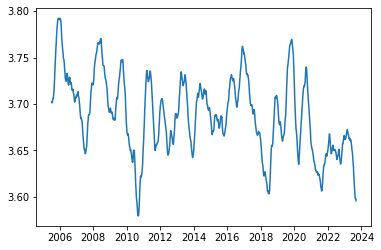

In [97]:
window_size = 120

# Calculate the rolling window average
v_smooth = np.convolve(v, np.ones(window_size) / window_size, mode='valid')

# Print the rolling average
print(len(v_smooth))
print(len(date[window_size-1:]))
plt.plot(date[window_size-1+300:],v_smooth[300:])

$\textbf{Simulated Annealing}$

In [98]:
import numpy as np
from scipy.optimize import dual_annealing

# Define the objective function to minimize

# Define the bounds for each variable
bounds = [(-.9, .9), (0.01, 2), (0.1, .4), (0.1, .2), (0.1,2)]  # Example bounds for two variables

# Run dual_annealing
result = dual_annealing(
    func= likelihood,
    bounds=bounds,
    maxiter=100,
    args=(price_series, dt),  # Pass the long series as an argument
    initial_temp=100,
    seed= 76,
    
)

# Print the results
print("Optimal Solution:", result.x)
print("Optimal Value:", result.fun)

Optimal Solution: [0.54410228 1.95491668 0.11335194 0.15397282 1.80470619]
Optimal Value: 2807636101.6542306


5129
5010
5010


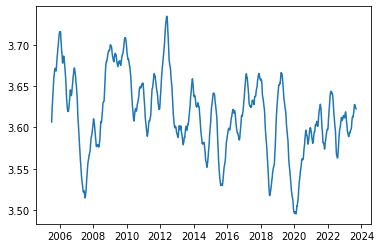

In [100]:
params = result.x
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
print(len(v))

#plt.plot(date[300:], v[300:])
window_size = 120

# Calculate the rolling window average
v_smooth = np.convolve(v, np.ones(window_size) / window_size, mode='valid')

# Print the rolling average
print(len(v_smooth))
print(len(date[window_size-1:]))
plt.plot(date[window_size-1+300:],v_smooth[300:])

In [101]:
initial_guess = params

bounds = [(-.9, .9), (0.01, 2), (0.1, .4), (0.1, .2), (0.1,2)] 


result = minimize(likelihood, initial_guess, bounds=bounds, args=(price_series, dt), method='Powell', options={'maxiter': 500})

# Extract estimated parameters
rho_est, kappa_est, theta_est, sigma_est, v0_est = result.x

print(f"Estimated Parameters:")
print(f"Rho: {rho_est}")
print(f"Kappa: {kappa_est}")
print(f"Theta: {theta_est}")
print(f"Sigma: {sigma_est}")
print(f"V0: {v0_est}")

Estimated Parameters:
Rho: 0.4818685520083604
Kappa: 1.4248005417701086
Theta: 0.17082039324993692
Sigma: 0.12597899659787198
V0: 0.5448823376711511


5129
4878
4878


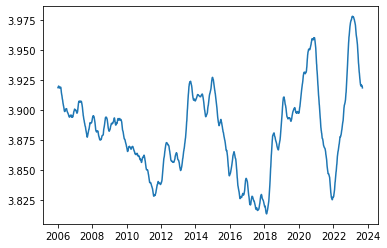

In [103]:
params = result.x
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
print(len(v))

#plt.plot(date[300:], v[300:])
window_size = 252

# Calculate the rolling window average
v_smooth = np.convolve(v, np.ones(window_size) / window_size, mode='valid')

# Print the rolling average
print(len(v_smooth))
print(len(date[window_size-1:]))
plt.plot(date[window_size-1+300:],v_smooth[300:])

In [106]:
import numpy as np
from pyswarm import pso

# Define the objective function to be minimized

junk = [.2,.2,.2,.1,.2]
lower_bound = params - junk
upper_bound = params + junk
lb = lower_bound
ub = upper_bound
c1 = 0.5  # Cognitive parameter
c2 = 0.3  # Social parameter
w = 0.9   # Inertia weight
maxiter = 100  # Maximum number of iterations

# Perform PSO optimization with additional arguments and defined parameters
parameters, value = pso(likelihood, lb, ub, args=(price_series, dt), debug=True, swarmsize=50, maxiter=maxiter, phip=c1, phig=c2, omega=w)

print("Optimal parameters:", parameters)
print("Optimal value:", value)

No constraints given.
New best for swarm at iteration 1: [ 0.40709622  1.62480054 -0.02917961  0.025979    0.63856544] 3819983159.750856
Best after iteration 1: [ 0.40709622  1.62480054 -0.02917961  0.025979    0.63856544] 3819983159.750856
New best for swarm at iteration 2: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 2: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 3: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 4: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 5: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 6: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration 7: [ 0.68186855  1.62480054 -0.02917961  0.025979    0.37786986] 3488105363.607728
Best after iteration

Best after iteration 74: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 75: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 76: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 77: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 78: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 79: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 80: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 81: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 82: [ 0.64342944  1.62480054 -0.0114131   0.03447031  0.36522665] 3229247992.6637444
Best after iteration 83: [ 0.64342944  1.62480

In [107]:
param = parameters
#print(param)
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
#print(len(v))
#print(sse)
#print(rsq)
#plt.plot(date3[300:], v[300:])
initial_guess = param
lb = param- [.1, .1, .1, .1, .1]
up = param + [.1, .1, .1, .1, .1]
#bounds = [(-.9, .9), (0.01, 2), (0.1, .4), (0.1, .4), (0.1,2)] 
bounds = list(zip(lb,ub))
result = minimize(likelihood, initial_guess, bounds = bounds, args=(price_series, dt), method='Powell', options={'maxiter': 500})
print(result.x)

[0.63011511 1.53554202 0.15320327 0.00762281 0.50859055]


5129
799852.1031290314
0.029926525322115923


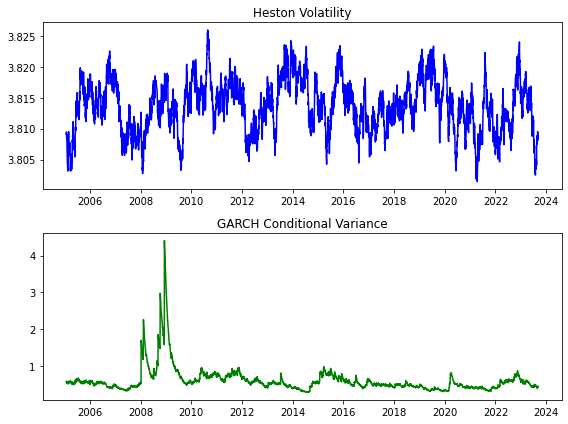

In [109]:
params = result.x
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
print(len(v))
print(sse)
print(rsq)
x1 = date[300:]
y1 = v[300:]

# Data for the second plot
x2 = date2[300:]
y2 = ConVar[300:]

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Plot the first set of data on the first subplot (top)
ax1.plot(x1, y1, label='Heston Volatility', color='blue')
ax1.set_title('Heston Volatility')
#ax1.legend()

# Plot the second set of data on the second subplot (bottom)
ax2.plot(x2, y2, label='GARCH Conditional Variance', color='green')
ax2.set_title('GARCH Conditional Variance')
#ax2.legend()

# Add some space between the two subplots
plt.tight_layout()

# Show or save the combined plot
plt.show()

In [110]:
param1_min, param1_max = bounds[0]
param2_min, param2_max = bounds[1]
param3_min, param3_max = bounds[2]
param4_min, param4_max = bounds[3]
param5_min, param5_max = bounds[4]
print(bounds)

[(0.5434294442908492, 0.6818685520083604), (1.5248005417701085, 1.6248005417701086), (-0.11141310486049036, 0.37082039324993693), (-0.06552968617641826, 0.225978996597872), (0.2652266472497671, 0.7448823376711511)]


In [111]:
def likelihood1(params, price_series, dt):
    simulated_price, simulated_returns, _, _, _ = heston_model(params, price_series, dt)
    actual_returns = 100* np.diff(np.log(price_series))
    model_returns = 100* simulated_returns
    residuals = (actual_returns - model_returns)
    sigma1 = np.std(residuals)
    log_likelihood = - .5 * sum((residuals/sigma1)**2) - .5 * np.pi * sigma1;
    # Calculate moments
    actual_moments = [np.mean(actual_returns), np.mean(actual_returns**2), np.mean(actual_returns**3), np.mean(actual_returns**4)]
    model_moments = [np.mean(model_returns), np.mean(model_returns**2), np.mean(model_returns**3), np.mean(model_returns**4)]
    
    # Calculate autocorrelations
    actual_returns_sq = actual_returns**2
    model_returns_sq = model_returns**2
    
    max_lag = 5  # Change this to the maximum lag you want to calculate
    actual_autocorr = np.corrcoef(actual_returns[:-max_lag], actual_returns[max_lag:])[0, 1]
    model_autocorr = np.corrcoef(model_returns[:-max_lag], model_returns[max_lag:])[0, 1]
    
    actual_autocorr_sq = np.corrcoef(actual_returns_sq[:-max_lag], actual_returns_sq[max_lag:])[0, 1]
    model_autocorr_sq = np.corrcoef(model_returns_sq[:-max_lag], model_returns_sq[max_lag:])[0, 1]
    
    # Calculate the sum of squared differences
    squared_diff =  np.sum((np.array(actual_moments + [actual_autocorr]+[actual_autocorr_sq]) - np.array(model_moments + [model_autocorr]+[model_autocorr_sq]))**2)
    # sdiff1 = (model_returns-actual_returns[1:])**2
    # squared_diff = np.sum(sdiff1)
    return -squared_diff  # Return a scalar value

In [112]:
#!pip install deap
from deap import base, creator, tools, algorithms

# Create the 'creator' object
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# Perform parameter estimation using minimize
options = {'maxiter': 1000,  # Maximum number of iterations
           'maxfev': 500   # Maximum number of function calls
                     }

creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

creator.create("FitnessMin", base.Fitness, weights=(1.0,))

# Define the individual representation, which includes the five parameters
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the bounds for each parameter
#param1_min, param1_max, param2_min, param2_max, param3_min, param3_max, param4_min, param4_max, param5_min, param5_max = zip(*bounds)

#param1_min, param1_max = -.9, .9
#param2_min, param2_max = 0.01, 5
#param3_min, param3_max = 0.01, 2
#param4_min, param4_max = 0.01, 2
#param5_min, param5_max = 0.01, 5

# Create an individual with random values within the defined bounds
def create_individual():
    return [
        random.uniform(param1_min, param1_max),
        random.uniform(param2_min, param2_max),
        random.uniform(param3_min, param3_max),
        random.uniform(param4_min, param4_max),
        random.uniform(param5_min, param5_max)
    ]

# Example of creating an individual
individual = create_individual()
toolbox = base.Toolbox()
# Define parameter boundaries
#varbound = np.array([[-0.9, 0.9], [0.001, 5], [0.001, 2.0], [0.001, 2.0], [0.001, 5.0]])
#bounds = [(-.99, .99), (0.001,5.0), (.001, 2.0), (.001, 2.0), (.001,5.0)] 

# Register functions for creating individuals and populations
toolbox.register("attr_float", np.random.uniform, 0.01, .99)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register other DEAP functions
toolbox.register("mate", tools.cxBlend, alpha=0.2)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)

# Set the number of generations and other parameters for GA
ngen = 80
cxpb = 0.6  # Crossover probability
mutpb = 0.2  # Mutation probability

# Create a population of 10 individuals for GA with variable boundaries
population = toolbox.population(n=50)

# Define custom evaluation function for GA
def eval_individual(individual):
    params = individual
    fitness = likelihood1(params, price_series, dt)
    return (fitness,)  # Wrap the fitness value in a tuple

# Register the evaluate function in the toolbox
toolbox.register("evaluate", eval_individual)

# Manually assign fitness values to individuals in the population
for ind in population:
    ind.fitness.values = eval_individual(ind)

# Create a Hall of Fame object to store the best individual from GA
hof = tools.HallOfFame(1)

# Define the GA statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)

# Get the best individual from the genetic algorithm
best_individual_ga = hof[0]

# Use the best individual from GA to initialize minimization
initial_guess = best_individual_ga


# Perform parameter estimation using minimize
options = {'maxiter': 2000, 'maxfev': 2000}
factor1 = 1.25
factor2 = .75
bounds1 = []
bounds2 = []


# Perform element-wise multiplication using a list comprehension
bounds1 = [val_ga * factor2 for val_ga in best_individual_ga]
bounds2 = [val_ga * factor1  for val_ga in best_individual_ga]
# bounds1 now contains the element-wise multiplication results
bounds_ga = list(zip(bounds1,bounds2))
print(bounds_ga)

result = minimize(likelihood, initial_guess, args=(price_series, dt), method='Nelder-Mead', options=options, bounds=bounds_ga)

# Extract estimated parameters
rho_est, kappa_est, theta_est, sigma_est, v0_est = result.x

print(f"Estimated Parameters:")
print(f"Rho: {rho_est}")
print(f"Kappa: {kappa_est}")
print(f"Theta: {theta_est}")
print(f"Sigma: {sigma_est}")
print(f"V0: {v0_est}")



C:\Users\mcnel\anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\mcnel\anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min         
0  	0     	-3.64402e+11
1  	36    	-1.6374e+10 
2  	36    	-1.00883e+10
3  	36    	-9.07444e+09
4  	36    	-8.47231e+09
5  	36    	-8.58174e+09
6  	36    	-9.96554e+09
7  	36    	-9.05864e+09
8  	36    	-9.18299e+09
9  	36    	-8.89333e+09
10 	36    	-8.5097e+09 
11 	36    	-8.78622e+09
12 	36    	-8.53639e+09
13 	36    	-9.26048e+09
14 	36    	-9.00506e+09
15 	36    	-9.48669e+09
16 	36    	-8.82157e+09
17 	36    	-9.18312e+09
18 	36    	-9.98859e+09
19 	36    	-8.40651e+09
20 	36    	-8.82081e+09
21 	36    	-8.95175e+09
22 	36    	-8.5402e+09 
23 	36    	-8.91285e+09
24 	36    	-8.56223e+09
25 	36    	-8.98738e+09
26 	36    	-8.64215e+09
27 	36    	-9.58871e+09
28 	36    	-8.72405e+09
29 	36    	-8.56382e+09
30 	36    	-8.85805e+09
31 	36    	-9.44885e+09
32 	36    	-8.52384e+09
33 	36    	-8.73456e+09
34 	36    	-8.57388e+09
35 	36    	-8.69511e+09
36 	36    	-9.03355e+09
37 	36    	-9.15458e+09
38 	36    	-8.80529e+09
39 	36    	-8.97843e+09
40 	36    	-9.11

5129
838144.0032048922
0.03130136356349349


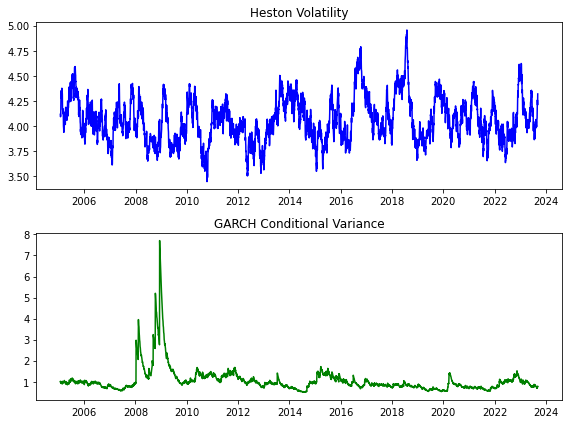

In [115]:
params = result.x
simulated_price, simulated_returns, v, sse, rsq = heston_model(params,price_series,dt)
print(len(v))
print(sse)
print(rsq)
start = 300
x1 = date[start:]
y1 = v[start:]
y1 = y1/y[0]

# Data for the second plot
x2 = date2[start:]
y2 = ConVar[start:]
y2 = y2/y2[0]

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Plot the first set of data on the first subplot (top)
ax1.plot(x1, y1, label='Heston Volatility', color='blue')
ax1.set_title('Heston Volatility')
#ax1.legend()

# Plot the second set of data on the second subplot (bottom)
ax2.plot(x2, y2, label='GARCH Conditional Variance', color='green')
ax2.set_title('GARCH Conditional Variance')
#ax2.legend()

# Add some space between the two subplots
plt.tight_layout()

# Show or save the combined plot
plt.show()
